# Homework

## Import packages

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

## Get data

In [2]:
file_name = 'input_data.xlsx'

In [3]:
orders = pd.read_excel(file_name, sheet_name='orders')
opportunities = pd.read_excel(file_name, sheet_name='opportunities')
accounts = pd.read_excel(file_name, sheet_name='accounts')

## Brief EDA

### Accounts table
- Primary key column = `account_id`
- No nulls
- Data type issues on the `account_id` and `sign_up_date`

In [4]:
accounts.head()

,account_id,account_type,sign_up_date,location
0,193482760.0,Customer,44866.0,North America
1,864920531.0,Partner,44904.0,North America
2,582037461.0,Customer,44933.0,LaTam
3,731592864.0,Customer,44944.0,EMEA
4,427105693.0,Customer,45000.0,APAC


In [5]:
accounts.shape

(10, 4)

In [6]:
accounts.nunique()

account_id      10
account_type     2
sign_up_date    10
location         4
dtype: int64

In [7]:
accounts.isnull().sum()

account_id      0
account_type    0
sign_up_date    0
location        0
dtype: int64

### Opportunities
- Primary key column = `opportunity_id`
- No nulls
- Data type issues on the `account_id` column

In [8]:
opportunities.head()

,opportunity_id,opportunity_name,account_id
0,C3V1F7Y9,Renegotiation: KCFYNE,193482760.0
1,D7V5X1P9,Renewal: WQXJRU,864920531.0
2,E5R4J7N1,Credit Amendment: NTRFQK,582037461.0
3,F0Q3S8L2,Renewal: VYTABO,731592864.0
4,G8P7F3K1,Renewal: AJWLDK,864920531.0


In [9]:
opportunities.shape

(20, 3)

In [10]:
opportunities.nunique()

opportunity_id      20
opportunity_name    20
account_id           9
dtype: int64

In [11]:
opportunities.isnull().sum()

opportunity_id      0
opportunity_name    0
account_id          0
dtype: int64

### Orders
- Primary key column: `order_id`
- No nulls
- An opportunity may be associated with multiple orders
- Data type issues on `account_id` and `create_date`

In [12]:
orders.head()

,order_id,opportunity_id,account_id,create_date,original_price,is_paid
0,Z5Q2X8T3J6R,C3V1F7Y9,193482760.0,44938.0,50000.0,Y
1,V9P4Z5M1D3R,D7V5X1P9,864920531.0,44984.0,175000.0,Y
2,W6J3L2F7P5Y,E5R4J7N1,582037461.0,44994.0,75000.0,Y
3,T1R6N8J2Q7L,F0Q3S8L2,731592864.0,45035.0,125000.0,Y
4,N4F1V9K3L8J,G8P7F3K1,864920531.0,45418.0,125000.0,Y


In [13]:
orders.shape

(50, 6)

In [14]:
orders.nunique()

order_id          50
opportunity_id    24
account_id        11
create_date       27
original_price     5
is_paid            2
dtype: int64

In [15]:
orders.isnull().sum()

order_id          0
opportunity_id    0
account_id        0
create_date       0
original_price    0
is_paid           0
dtype: int64

In [16]:
orders[orders['opportunity_id']== 'C3V1F7Y9']

,order_id,opportunity_id,account_id,create_date,original_price,is_paid
0,Z5Q2X8T3J6R,C3V1F7Y9,193482760.0,44938.0,50000.0,Y
20,A3B7C9D2F1G,C3V1F7Y9,193482760.0,45114.0,125000.0,Y


In [17]:
orders[orders['opportunity_id']== 'Y9B2L0T6']

,order_id,opportunity_id,account_id,create_date,original_price,is_paid
17,G2M5X7T1V9Q,Y9B2L0T6,302186547.0,45180.0,125000.0,Y
37,S7M3Q5R1P2K,Y9B2L0T6,302186547.0,45180.0,125000.0,Y
42,KDCYTNRRTK9,Y9B2L0T6,302186547.0,45180.0,50000.0,Y


## Fix data type issues
Fix account_id and dates fields. Initially, I used pandas to fix the data types, but later I moved this step to SQL.

In [18]:
# fix account_id

# orders['account_id'] = orders['account_id'].astype('Int64')
# opportunities['account_id'] = opportunities['account_id'].astype('Int64')
# accounts['account_id'] = accounts['account_id'].astype('Int64')

In [19]:
# fix date columns 
# assume that the date field represents the # days after 1900-01-01
# correcting for Excel leap year bug (incorrectly assumes that 1900 was a leap year)
# need to subtract 2 days from the number to align

# orders['create_date'] = pd.to_datetime(orders['create_date']-2, origin='1900-01-01', unit='D')
# accounts['sign_up_date'] = pd.to_datetime(accounts['sign_up_date']-2, origin='1900-01-01', unit='D')

## Tables schemas
Following the initial EDA, the schema below shows the tables and their corresponding relationships

In [20]:
## Schema Diagram
## PK: Primary Key
## FK: Foreign Key


## +----------------+            +--------------------+           +-------------------+
## |   accounts     |            |   opportunities    |           |     orders        |
## |----------------|            |--------------------|           |-------------------|
## | account_id (PK)|<------     | opportunity_id (PK)|<----|     | order_id (PK)     |
## | account_type   |    ^ |     | opportunity_name   |     |---->| opportunity_id(FK)|
## | sign_up_date   |    |  ---->| account_id (FK)    |<--------->| account_id (FK)   |
## | location       |    |       +--------------------+      ^    | create_date       |
## +----------------+    |                                   |    | original_price    |
##                       ------------------------------------     | is_paid           |
##                                                                +-------------------+

## Relationships:

## - accounts → opportunities (one-to-many): one account can have multiple opportunities.
## - opportunities → orders (one-to-many): one opportunity can have multiple orders.
## - orders → accounts (many-to-one): many orders can belong to the same account.

## Part 1

### Question 1
Using the tables, please design a query which the output captures all the accounts in an 'account_summary'; and the following fields: 
- a) account_id
- b) account location broken out by North America vs All Other
- c) The time lag (in days) between the account sign-up date and first order date 
- d) # of opportunities since 2H of this year
- e) # of lifetime orders
- f) $ of lifetime orders gross revenue

In [21]:
# create an SQLite in memory database connection
connection = sqlite3.connect(':memory:')

# write the dataframes to SQL tables
accounts.to_sql('accounts', connection, index=False, if_exists='replace')
opportunities.to_sql('opportunities', connection, index=False, if_exists='replace')
orders.to_sql('orders', connection, index=False, if_exists='replace')

**Notes and assumptions**:
- Not all account IDs in the `orders` table exist in the `accounts` table, and vice versa. I would have expected the `accounts` table to serve as the master source for all account information containing every account ID. However, there are some account IDs present in the `orders` table that are not found in the accounts table.

- Two accounts have their first order date before their sign-up date, which looks like a data quality issue. Because of this, those accounts show negative values in the `days_until_first_order` column. Accounts without any orders will show `NULL` in that column, and accounts without a sign-up date (because they are not in the `accounts` table) will also have `NULL` values.

- Normally I would use `datediff` to find the difference between two dates, but SQLite does not have that function. Instead, I used `julianday()` to calculate the difference. Also, the `dateadd` function is not available, so my choice of functions may differ from what I would typically use in other database systems.

- **"Opportunities since 2H of this year" is assumed to mean 2024**, since there is no data for 2025. Opportunities don’t have a specific date, so I’m using the `create_date` from the related order(s) instead.

- `gross_revenue` includes all orders (paid and unpaid).


#### Not all accounts in the orders table are in the accounts table

In [22]:
# create the query
check_query = '''

select 
  distinct cast(account_id as INT) as account_id
from orders
where account_id not in (select distinct account_id from accounts)

'''

# execute the query
result = pd.read_sql(check_query, connection)

# display the result
result


,account_id
0,205314271
1,654773125


#### Not all accounts in the accounts table are in the orders table
This is expected as these probably represent accounts that haven't ordered anything yet.

In [23]:
# create the query
check_query = '''

select 
  distinct cast(account_id as INT) as account_id
from accounts
where account_id not in (select distinct account_id from orders)

'''

# execute the query
result = pd.read_sql(check_query, connection)

# display the result
result

,account_id
0,631054827


In [24]:
# create the query
q1_query = '''

-- change the types of the dates and account_id
with ords as (

  select 
    order_id,
    opportunity_id,
    cast(account_id as INT) as account_id,
    date('1900-01-01', '+' || (create_date - 2) || ' days') as create_date,
    original_price,
    is_paid  
  from orders

),

-- change the types of the dates and account_id
acc as (

  select 
    cast(account_id as INT) as account_id,
    account_type,
    date('1900-01-01', '+' || (sign_up_date - 2) || ' days') as sign_up_date,
    location   
  from accounts

),

-- change the types of the dates and account_id
opp as (

  select
    opportunity_id,
    opportunity_name,
    cast(account_id as INT) as account_id
  from opportunities
  
),


-- create a table with all account IDs
-- as the accounts table does not contain all IDs
acc_ids as (

  select 
    distinct account_id
  from acc
  
  union
  
  select 
    distinct account_id
  from ords

),

-- get the summary of orders by account
orders_by_acc as (

  select 
    account_id, 
    min(create_date) as first_order_date,
    count(distinct order_id) as lifetime_orders,
    sum(original_price) as gross_revenue,
    count(distinct 
      case when create_date >= '2024-07-01' and create_date <= '2024-12-31' 
        then opportunity_id 
      end
    ) as total_opps_2h
  from ords
  group by 1
  
)

-- final joins
select 
  acc_ids.account_id,
  (case 
    when acc.location = 'North America' then 'North America' 
    when acc.location is Null then Null
    else 'All Other' 
  end) as region,
  julianday(orders_by_acc.first_order_date) - julianday(acc.sign_up_date) as days_until_first_order,
  ifnull(orders_by_acc.total_opps_2h, 0) as total_opps_2h,
  ifnull(orders_by_acc.lifetime_orders, 0) as lifetime_orders,
  ifnull(orders_by_acc.gross_revenue, 0) as gross_revenue
from acc_ids
left join acc
  on acc_ids.account_id = acc.account_id
left join orders_by_acc
  on acc_ids.account_id = orders_by_acc.account_id

'''

# execute the query
result = pd.read_sql(q1_query, connection)

# export to excel
result.to_excel("account_summary_table.xlsx", index=False)

# display the result
result

,account_id,region,days_until_first_order,total_opps_2h,lifetime_orders,gross_revenue
0,193482760,North America,72.0,1,6,650000.0
1,205314271,None,NaN,0,3,275000.0
2,302186547,All Other,-97.0,1,5,425000.0
3,427105693,All Other,92.0,1,6,475000.0
4,569431028,All Other,-184.0,1,4,350000.0
5,582037461,All Other,61.0,0,4,300000.0
6,631054827,North America,NaN,0,0,0.0
7,654773125,None,NaN,0,2,300000.0
8,731592864,All Other,91.0,0,5,675000.0
9,864920531,North America,80.0,1,10,1325000.0


### Question 2
- How many accounts are in the top 10% ranked by their aggregate order gross revenue?

In [25]:
# create the query
q2_query = '''

-- change the types of the dates and account_id
with ords as (

  select 
    order_id,
    opportunity_id,
    cast(account_id as INT) as account_id,
    date('1900-01-01', '+' || (create_date - 2) || ' days') as create_date,
    original_price,
    is_paid  
  from orders

),

-- change the types of the dates and account_id
acc as (

  select 
    cast(account_id as INT) as account_id,
    account_type,
    date('1900-01-01', '+' || (sign_up_date - 2) || ' days') as sign_up_date,
    location   
  from accounts

),

-- create a table with all account IDs
acc_ids as (

  select 
    distinct account_id
  from acc
  
  union
  
  select 
    distinct account_id
  from ords
  
),

-- get the revenue by account
rev_by_acc as (

  select 
    account_id, 
    sum(original_price) as gross_revenue
  from ords
  group by 1
  
),

final as (

  select 
    acc_ids.account_id,
    ifnull(rev_by_acc.gross_revenue, 0) as gross_revenue,
    percent_rank() over (order by ifnull(rev_by_acc.gross_revenue, 0) desc) as percent_rank 
  from acc_ids
  left join rev_by_acc
    on acc_ids.account_id = rev_by_acc.account_id
    
)

select
  count(distinct account_id) as top_10_acc_count
from final
where percent_rank <= 0.1

'''

# execute the query 
result = pd.read_sql(q2_query, connection)

# display the result
result

,top_10_acc_count
0,2


### Question 3
- For paid orders, what is the mean, median, 25th percentile, 75th percentile, and top 1% of original order prices? (calculated as gross orders sales / orders sold)?

**Notes and assumptions:** 

- I wasn't completely clear on the question, so I went ahead and calculated the statistics for the `original_price` column on the `orders` table, considering only paid orders. I reached out for clarification but didn’t receive a response. I hope this approach is acceptable. 

In [26]:
q3_query = """

-- change the types of the dates and account_id
-- filter paid orders
-- order the data
with paid_orders as (

  select 
    order_id,
    opportunity_id,
    cast(account_id as INT) as account_id,
    date('1900-01-01', '+' || (create_date - 2) || ' days') as create_date,
    original_price,
    is_paid,
    row_number() over (order by original_price) as row_num,
    count(*) over() as total_rows
  from orders
  where is_paid = 'Y'
  order by original_price

),

-- need to consider when total rows are odd and even
statistics as (

  -- p50 calculation (i.e., median)
  select 
  -- odd number of rows
  case 
    when total_rows % 2 = 1 
    then (select original_price from paid_orders where row_num = (total_rows + 1) / 2)
  -- even number of rows (average the two middle values)
    when total_rows % 2 = 0 
    then (select avg(original_price) from paid_orders where row_num in (total_rows / 2, (total_rows / 2) + 1))
  end as p50,
  
  -- p25 calculation
  case 
  -- odd number of rows
    when total_rows % 2 = 1 
    then (select original_price from paid_orders where row_num = (total_rows + 1) / 4)
  -- even number of rows (average the two middle values)
    when total_rows % 2 = 0 
    then (select avg(original_price) from paid_orders where row_num in (total_rows / 4, (total_rows / 4) + 1))
  end as p25,
  
  -- p75 calculation
  case 
  -- odd number of rows
    when total_rows % 2 = 1 
    then (select original_price from paid_orders where row_num = (total_rows + 1) * 3 / 4)
  -- even number of rows (average the two middle values)
    when total_rows % 2 = 0 
    then (select avg(original_price) from paid_orders where row_num in (total_rows * 3 / 4, (total_rows *3 / 4) + 1))
  end as p75,
  
  -- p99 calculation
  case 
  -- odd number of rows
    when total_rows % 2 = 1 
    then (select original_price from paid_orders where row_num = (total_rows + 1) * 99 / 100)
  -- even number of rows (average the two middle values)
    when total_rows % 2 = 0 
    then (select avg(original_price) from paid_orders where row_num in (total_rows * 99 / 100, (total_rows *99 / 100) + 1))
  end as p99,
  
  round(avg(original_price),1) as average
  
  from paid_orders
  limit 1
  
)

select *
from statistics

"""

# execute the query 
result = pd.read_sql(q3_query, connection)

# display the result
print('Original Price statistics:')
result

Original Price statistics:


,p50,p25,p75,p99,average
0,100000.0,50000.0,125000.0,200000.0,106547.6


### Question 4
- Plot the relationship between the original order price and the orders sold for each opportunity stage

**Notes and assumptions**: 
- Not all `opportunity_id` listed in the `orders` table are present in the `opportunities` table
- Assumed that the stage of the opportunity is included in the opportunity name.
- Assumed following order in the stages:
    - 1) New Customer: The first stage, where a new customer signs a contract
    - 2) Additional Contract: This would come next if the customer decides to add more services/products to the original agreement
    - 3) Renegotiation: This might come after when both parties want to modify existing terms
    - 4) Credit Amendment: This stage might occur if there are financial or payment related adjustments that need to be made
    - 5) Renewal: This would typically follow the end of the contract, where both parties agree to renew the terms of the agreement
    - Other: This category includes all orders that don't have an assigned stage, either because no opportunities are associated in the `opportunities` table, or because the stage cannot be determined from the associated opportunity.
- Normally, I would use **Tableau** to visualize this data since it is much quicker and easier to create high quality plots. Unfortunately, I don’t have a personal license for Tableau, so I ended up using Matplotlib and Seaborn instead. It took a lot more time and effort to make the plots and the quality is not as high as what I could get in Tableau.


In [27]:
q4_query = """

with opps as (
  select
    *,
    case 
      when lower(opportunity_name) like '%renegotiation%' then 'Renegotiation'
      when lower(opportunity_name) like '%renewal%' then 'Renewal'
      when lower(opportunity_name) like '%credit amendment%' then 'Credit Amendment'
      when lower(opportunity_name) like '%additional contract%' then 'Additional Contract'
      when lower(opportunity_name) like '%new customer%' then 'New Customer'
      else 'Other'
    end as opportunity_stage   
  from opportunities
),

ords as (

  select 
    orders.order_id,
    orders.opportunity_id,
    orders.original_price,
    ifnull(opps.opportunity_stage, 'Other') as opportunity_stage -- assign Other where opp is not found
  from orders
  left join opps
  on orders.opportunity_id = opps.opportunity_id

)

select
  opportunity_stage,
  round(avg(original_price),1) as avg_price,
  count(distinct order_id) as orders_count
from ords
group by 1


"""

# execute the query 
result = pd.read_sql(q4_query, connection)

# display the result
result

,opportunity_stage,avg_price,orders_count
0,Additional Contract,95000.0,5
1,Credit Amendment,70833.3,6
2,New Customer,100000.0,3
3,Other,106818.2,11
4,Renegotiation,102777.8,9
5,Renewal,117187.5,16


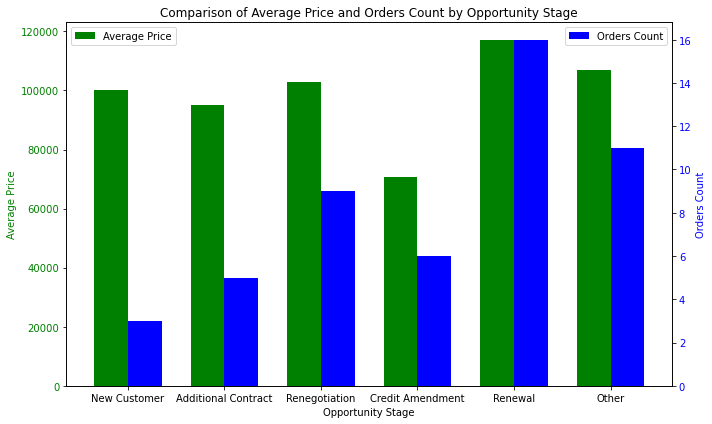

In [28]:
# plot to compare average price and orders count

# sorting by opportunity_stage 
stage_order = ['New Customer', 'Additional Contract', 'Renegotiation', 'Credit Amendment', 'Renewal', 'Other']
result['opportunity_stage'] = pd.Categorical(result['opportunity_stage'], categories=stage_order, ordered=True)
result = result.sort_values('opportunity_stage')

n_bars = len(result)

x = np.arange(n_bars)

# bar width
width = 0.35  

# axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# plot avg_price
bars1 = ax1.bar(x - width/2, result['avg_price'], width, label='Average Price', color='green')

# labels and title
ax1.set_xlabel('Opportunity Stage')
ax1.set_ylabel('Average Price', color='green')
ax1.set_title('Comparison of Average Price and Orders Count by Opportunity Stage')

# axis ticks 
ax1.set_xticks(x)
ax1.set_xticklabels(result['opportunity_stage'])

# color the axis to match the variable
ax1.tick_params(axis='y', labelcolor='green')

# plot orders_count (on a different axis)
ax2 = ax1.twinx()
bars2 = ax2.bar(x + width/2, result['orders_count'], width, label='Orders Count', color='blue')

# set label and color 
ax2.set_ylabel('Orders Count', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')


# legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# show the plot
plt.tight_layout()
plt.show()



### Question 5
What are some of your other observations of the data?

### Observations of the Data

- **About data integrity.** As mentioned before there are some data integrity issues:
  - The `accounts` table does not include all `account_id` found in the `orders` table.  
  - The `opportunities` table does not include all `opportunity_id` listed in the `orders` table.  
  These tables should act as the master tables for accounts and opportunities in the database, meaning they should be the source of truth for this data.
  - It is not ideal to include the opportunity stage as part of the opportunity name unless the naming process is automated and takes the opportunity stage into account. In general, it is better to have the opportunity stage as a separate column in the `opportunities` table. Additionally, what the homework considers the opportunity stage actually more closely resembles the opportunity type (e.g., New customer, additional contracts/upsells, renewals, etc.). Opportunity stages typically refer to the current status of an opportunity, such as open, negotiating, closed won, or closed lost.

- **About data quality.** There are some data quality issues:
  - Two accounts have their first order date before their sign-up date, which suggests a potential data entry issue.  
  - Data types are not well defined for dates and the `account_id` field across the tables.

- **About the data trends**:  
  - There were more orders in **2024** than in **2023**, indicating growth. 
  - The quarters with the most orders were **Q1** and **Q3**, for both years. 
  - **Renewal opportunities** are the most common, and they also have the highest average price at **117k**.
  - **Additional contracts** are also common, indicating that existing customers frequently return to add more products or subscriptions, with average order sizes around **95K**.
  - Opportunities related to **New Customers** are the least common, but their average order size is **100K**, which is quite close to the average size of Additional Contracts.
  - On average **Renewal opportunities** have the highest average price, but there is also significant variability in prices, ranging from **50K** to **175K** (as seen in the box-plot). 
- As I mentioned before, normally I would use **Tableau** to visualize this data. Unfortunately, I don’t have a personal license for Tableau, so I ended up using Matplotlib and Seaborn instead. It took a lot more time and effort to make the plots and the quality is not as high as what I could get in Tableau.

In [29]:
## query to create some extra plots
q5_query = """

with opps as (
  select
    *,
    case 
      when lower(opportunity_name) like '%renegotiation%' then 'Renegotiation'
      when lower(opportunity_name) like '%renewal%' then 'Renewal'
      when lower(opportunity_name) like '%credit amendment%' then 'Credit Amendment'
      when lower(opportunity_name) like '%additional contract%' then 'Additional Contract'
      when lower(opportunity_name) like '%new customer%' then 'New Customer'
      else 'Other'
    end as opportunity_stage   
  from opportunities
),

ords as (

  select 
    orders.order_id,
    orders.opportunity_id,
    cast(orders.account_id as INT) as account_id,
    date('1900-01-01', '+' || (orders.create_date - 2) || ' days') as create_date,
    orders.original_price,
    orders.is_paid,
    ifnull(opps.opportunity_stage, 'Other') as opportunity_stage -- assign Other where opp is not found
  from orders
  left join opps
  on orders.opportunity_id = opps.opportunity_id

)

select
 *
from ords

"""

# execute the query 
result = pd.read_sql(q5_query, connection)

# display the result
result

,order_id,opportunity_id,account_id,create_date,original_price,is_paid,opportunity_stage
0,Z5Q2X8T3J6R,C3V1F7Y9,193482760,2023-01-12,50000.0,Y,Renegotiation
1,V9P4Z5M1D3R,D7V5X1P9,864920531,2023-02-27,175000.0,Y,Renewal
2,W6J3L2F7P5Y,E5R4J7N1,582037461,2023-03-09,75000.0,Y,Credit Amendment
3,T1R6N8J2Q7L,F0Q3S8L2,731592864,2023-04-19,125000.0,Y,Renewal
4,N4F1V9K3L8J,G8P7F3K1,864920531,2024-05-06,125000.0,Y,Renewal
5,B8F3W9K2X7L,H9M4T2J7,427105693,2023-06-15,50000.0,Y,Additional Contract
6,H7V9F2L3T5C,K6J9B1M4,205314271,2024-01-15,75000.0,Y,Renegotiation
7,C5M4Z2R9K1F,L2F7J6D4,193482760,2023-08-04,175000.0,N,Other
8,W3K1Y6J7B4X,N4X5Y7V2,864920531,2023-09-11,50000.0,Y,Additional Contract
9,D8B5N1L0TQ9,P6T4K1E9,582037461,2024-04-10,50000.0,Y,Renewal


### Plot average price distribution per opportunity stage

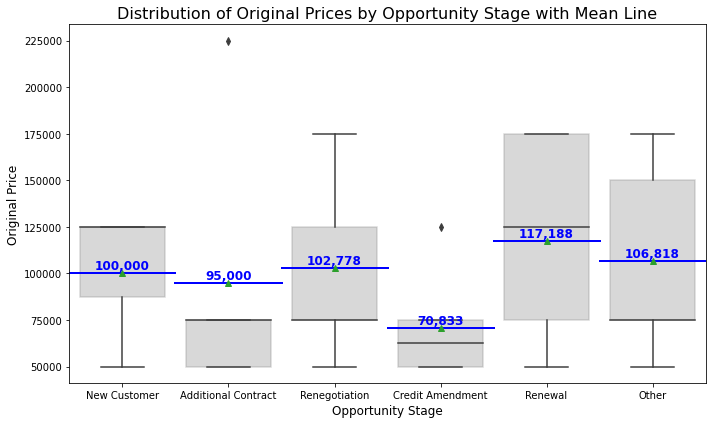

In [30]:
# sorting by opportunity_stage 
stage_order = ['New Customer', 'Additional Contract', 'Renegotiation', 'Credit Amendment', 'Renewal', 'Other']
result['opportunity_stage'] = pd.Categorical(result['opportunity_stage'], categories=stage_order, ordered=True)
result = result.sort_values('opportunity_stage')

# create plot
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x='opportunity_stage', y='original_price', 
                 data=result, showmeans=True,
                boxprops=dict(facecolor='#f0f0f0', color='gray', alpha=0.3))

# calculate mean
mean_values = result.groupby('opportunity_stage')['original_price'].mean()

# plot the mean and add a label
for i, stage in enumerate(result['opportunity_stage'].unique()):
    # red line
    ax.plot([i - 0.5, i + 0.5], [mean_values[stage], mean_values[stage]], color='blue', lw=2)
    
    # label
    ax.text(i, mean_values[stage] + 2000, f'{mean_values[stage]:,.0f}', 
            ha='center', color='blue', fontsize=12, fontweight='bold')

# add title and labels
plt.title('Distribution of Original Prices by Opportunity Stage with Mean Line', fontsize=16)
plt.xlabel('Opportunity Stage', fontsize=12)
plt.ylabel('Original Price', fontsize=12)

# show the plot
plt.tight_layout()
plt.show()


### Plot orders per year and orders per quarter

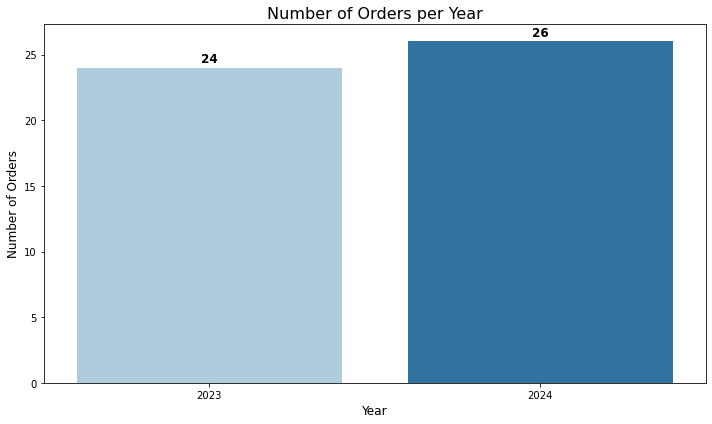

In [31]:
# convert create_date to datetime format
result['create_date'] = pd.to_datetime(result['create_date'])

# extract year
result['year'] = result['create_date'].dt.year

# count the number of orders per year
order_counts_per_year = result['year'].value_counts().sort_index()

# create the plot
plt.figure(figsize=(10, 6))

# define a color palette 
palette = sns.color_palette("Paired", len(result['year'].unique()))

sns.barplot(x=order_counts_per_year.index, y=order_counts_per_year.values, palette=palette)

# add labels on top of each bar
for i, count in enumerate(order_counts_per_year.values):
    plt.text(i, count + 0.2, f'{count}', ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

# add labels and title
plt.title('Number of Orders per Year', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Orders', fontsize=12)

# show the plot
plt.tight_layout()
plt.show()


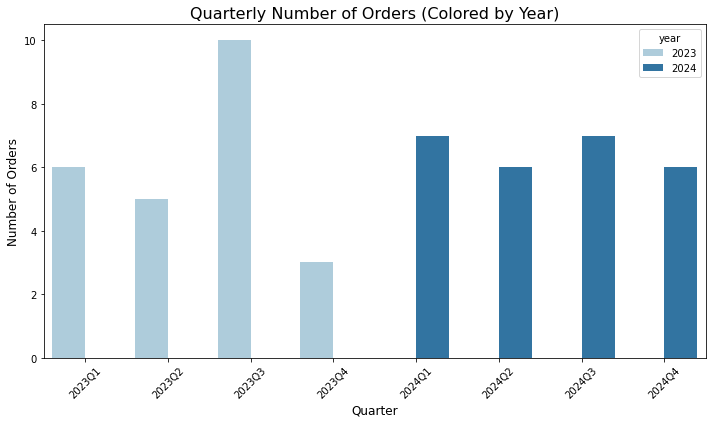

In [32]:
# extract year and quarter from create_date
result['year_quarter'] = result['create_date'].dt.to_period('Q') 

# count the number of orders per quarter and year
quarterly_order_counts = result.groupby(['year_quarter', 'year']).size().reset_index(name='order_count')

# create the plot 
plt.figure(figsize=(10, 6))

# define a color palette 
palette = sns.color_palette("Paired", len(quarterly_order_counts['year'].unique()))

# create the bar plot
ax = sns.barplot(x='year_quarter', y='order_count', hue='year', data=quarterly_order_counts, palette=palette)

# add labels and title
plt.title('Quarterly Number of Orders (Colored by Year)', fontsize=16)
plt.xlabel('Quarter', fontsize=12)
plt.ylabel('Number of Orders', fontsize=12)

# rotate labels
plt.xticks(rotation=45)

# show the plot
plt.tight_layout()
plt.show()



In [33]:
# close the connection
connection.close()

## Part 2

### Question 1- What are our monthly quantities of orders sold for opportunities in EMEA?

To determine the monthly quantities of orders sold for opportunities in the EMEA region, we need to follow these steps:

#### 1) Identify opportunities in EMEA
- Each order in the `orders` table has an associated `opportunity_id`.
- The `opportunities` table contains the `opportunity_id` and links to the `account_id`.
- Each `account_id` in the `accounts` table has a `location`, which helps us determine whether the opportunity is in the EMEA region.

#### 2) Joins
- First, we need to join the `orders` table with the `opportunities` table on the `opportunity_id` to match each order with its associated opportunity.
- After, we join the `opportunities` table with the `accounts` table using `account_id` to retrieve the `location` information for each opportunity.

#### 3) Filter EMEA region
- Once the tables are joined, filter the data to only include orders where the `location` corresponds to the EMEA region.

#### 4) Calculate monthly orders
- After identifying the relevant orders in the EMEA region, we can group the data by month using the `created_date` from the `orders` table.
- For each month we will count the distinct `order_id` values to determine the number of orders sold.
- The result should display `month_of_order` and `total_orders`, ordered by `month_of_order`.


**Note**: The `orders` table also includes an `account_id`, which we could use to determine the `location` of the account, **IF** the `account_id` in the `orders` table matches the one in the `opportunities` table for the associated `opportunity_id`. The steps above do not assume this, but if we do, we could go directly from the `orders` table to the `accounts` table, skipping the `opportunities` table.



### Question 2 - Who is our top 5 accounts by paid orders sold in the past 365 days? - They need the account’s email address and number of paid orders per account

To find this we can follow the steps below:

#### 1) Filter paid orders from the past 365 days
   - Filter the `orders` table to only include orders where `is_paid = 'Y'`.
   - Filter the `create_date` of the orders to be within the last 365 days from the current date.

#### 2) Group orders by account
   - Group the filtered `orders` table  by `account_id`.
   - Count the distinct `order_id` for each `account_id` to determine how many paid orders each account has placed.

#### 3) Join with the accounts table to get account information
   - Once we have the paid order count per account, we need to join with the `accounts` table using `account_id` to get account details (like `email_address` associated with the account).
   - The `email_address` is not currently available in the `accounts` table and should be included.

#### 4) Rank accounts by number of paid orders
   - Rank the accounts based on the number of paid orders.
   - Select the top 5 accounts with the highest number of paid orders in the past 365 days.
   - The result should display the top 5 accounts by the number of paid orders, including their `account_id`,   `email_address`, and the `paid_orders_count` per account.


### Question 3 - How many accounts who signed up in 2020 have sold at least one paid order, but never a discounted order?


To find this we can follow the steps below:

#### 1) Filter accounts by sign-up date
   - Filter the `accounts` table to only include accounts that signed up in 2020 using the `sign_up_date` field. 
   - **Note:** We need to ensure that the `accounts` table is complete and contains information of all the accounts.

#### 2) Count paid orders  and  discounted orders per account
   - Group the `orders` table by `account_id` and:
       - Count the distinct `order_id` values where `is_paid = 'Y'`. This will give us the number of paid orders per account.
       - Count the distinct `order_id` values where `is_discounted = 'Y'`. This will give us the number of discounted orders per account.      
   - **Note:** Currently, there is no column to identify discounted orders. To implement this step, we would need to add a column (e.g., `is_discounted`) to the `orders` table to mark orders that have discounts. Without this, is not possible to identify discounted orders.

#### 3) Join Accounts with the information of paid orders  and  discounted orders
   - Join the filtered `accounts` table with the result of the paid/discounted orders count, based on `account_id`.
   - Filter accounts that have no discounted order (`discounted_orders_count = 0`) and at least one paid order (`paid_orders_count > 0`).
   - The result should display the number of accounts (`count distinct account_id`).